# Querying news articles via Stardog

News articles ingested in the notebook, Demo_Article_Ingest, with execution/visualization of:
* 

In [7]:
import os
import stardog

sd_dna = 'dna'
sd_conn_details = {'endpoint': os.environ.get('STARDOG_ENDPOINT'),
                   'username': os.getenv('STARDOG_USER'),
                   'password': os.environ.get('STARDOG_PASSWORD')}

In [ ]:
# 'ceasefire', 'fl_abortion', 'trump_bond', 'trump_trial'
article_collection = 'ceasefire'  

# 'Al Jazeera', 'Breitbart', 'CNN', 'Fox News', 'Huffington Post',
# 'New York Times', 'Wall Street Journal', Washington Times' 
sources = ['Breitbart', 'CNN', 'Wall Street Journal']  

# Mentions of first/last, first or last names
names_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select ?agent ?source (COUNT(?agent) as ?cnt) where {' \
    '   {graph ?defGraph {?s a :Narrative ; :source ?source}} ' \
    '   BIND(IRI(CONCAT("urn:ontoinsights:dna:", STRAFTER(str(?s), "Narrative_"))) as ?g) . ' \
    '   {graph ?narrGraph {?narr :mentions ?agent . ?agent a :Person}} ' \
    '} GROUP BY ?agent ?source ORDER BY ?agent ?source'

# Events and actors
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select ?offset ?event ?actor where {' \
    '   {graph ?defGraph {?s a :Narrative ; :source ?source}} ' \
    '   BIND(IRI(CONCAT("urn:ontoinsights:dna:", STRAFTER(str(?s), "Narrative_"))) as ?g) . ' \
    '   {graph ?narrGraph {?sent :offset ?offset ;  :mentions ?agent . ?agent a :Person}} ' \
    '} GROUP BY ?agent ?source ORDER BY ?agent ?source'


In [8]:
# Mentions of first/last, first or last names
names_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select ?agent ?publisher (COUNT(?agent) as ?cnt) from ?graph where {' \
    '   ?s a :Narrative ; dc:publisher ?publisher . ' \
    '   BIND(IRI(CONCAT("urn:ontoinsights:dna:", STRAFTER(str(?s), "Narrative_"))) as ?g) . ' \
    '{graph ?g {?narr :mentions ?agent . ?agent a :Person}}} GROUP BY ?agent ?publisher ORDER BY ?agent ?publisher'

conn = stardog.Connection(sd_dna, **sd_conn_details)

query_results = conn.select(query, content_type='application/sparql-results+json')
if 'results' in query_results and 'bindings' in query_results['results']:
    bindings = query_results['results']['bindings']
else:
    bindings = []

person_mentions_dict = dict()
publisher_dict = {'Breitbart': 0, 'Fox News': 1, 'Wall Street Journal': 2, 'New York Times': 3}
for binding in bindings:
    person = binding['agent']['value'].split(':dna:')[1]
    publisher = binding['publisher']['value']
    count = int(binding['cnt']['value'])
    if person in person_mentions_dict:
        count_array = person_mentions_dict[person]
    else:
        count_array = [0, 0, 0, 0]
    count_array[publisher_dict[publisher]] = count
    person_mentions_dict[person] = count_array

print(person_mentions_dict)

{'Abraham_Lincoln': [5, 1, 0, 1], 'Dick_Cheney': [0, 0, 1, 0], 'Donald_Trump': [2, 3, 7, 0], 'Harriet_Hageman': [1, 5, 2, 2], 'Joe_Biden': [0, 0, 1, 0], 'Liz_Cheney': [13, 5, 7, 6], 'Martin_Luther_King_Jr_': [0, 0, 0, 1], 'Trump': [4, 0, 0, 0], 'Ulysses_S_Grant': [1, 0, 0, 3], 'WYOMING': [0, 1, 0, 0]}


In [15]:
# Breitbart events from the first 5 paragraphs
query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select distinct ?sentenceOffset ?chunkOffset ?chunkText ?eventLabel where { ' \
    '  ?s a :Narrative ; dc:publisher "Breitbart" . ' \
    '  BIND(IRI(CONCAT("urn:ontoinsights:dna:", STRAFTER(str(?s), "Narrative_"))) as ?g) . ' \
    '  {graph ?g {?sentence a :Sentence ; :offset ?sentenceOffset .' \
    '     OPTIONAL {?sentence :has_component ?chunk . ?chunk :offset ?chunkOffset ; :text ?chunkText . ' \
    '        OPTIONAL {?chunk :describes ?event . ?event rdfs:label ?eventLabel}}}}} ' \
    'ORDER BY ?sentenceOffset ?chunkOffset' 

conn = stardog.Connection('short-news-db', **sd_conn_details)

query_results = conn.select(query, content_type='application/sparql-results+json')
if 'results' in query_results and 'bindings' in query_results['results']:
    bindings = query_results['results']['bindings']
else:
    bindings = []

story_arc_dict = dict()
for binding in bindings:
    sent_offset = int(binding['sentenceOffset']['value'])
    chunk_offset = int(binding['chunkOffset']['value']) - 1
    if 'eventLabel' in binding:
        label = binding['eventLabel']['value']
    else:
        label = binding['chunkText']['value']
    if sent_offset in story_arc_dict:
        arc_text = story_arc_dict[sent_offset] + '\n'
    else:
        arc_text = ''
    lf_label = ''
    add_new_line = False
    for i in range(0,len(label)):
        if i in (20, 40, 60):
            add_new_line = True
        if i >= 75:
            break
        if add_new_line and label[i] == ' ':
            add_new_line = False
            lf_label += '\n'
        else:
            lf_label += label[i]
    arc_text += lf_label 
    story_arc_dict[sent_offset] = arc_text

print(story_arc_dict)

{1: 'Cheney compared Cheney,\nto Lincoln during\nher concession speech\nshortly aft', 3: 'Cheney claimed\nCheney fail to go along\nwith President Trump\nâ€™s lie about 2020\nelection$&be\nCheney lost her primary\nelection', 5: 'Quotation0\nQuotation1', 6: 'Cheney said', 8: 'Cheney said\nmembers of congress swear\nto protect principles\nher opposition to former\nPresident Donald\nTrump, rooted in principles\nCheney understood potential\npolitical consequences\nof opposing\nTrump', 10: 'Lincoln saved nation\ncompared to Lincoln'}


# Demo Outputs

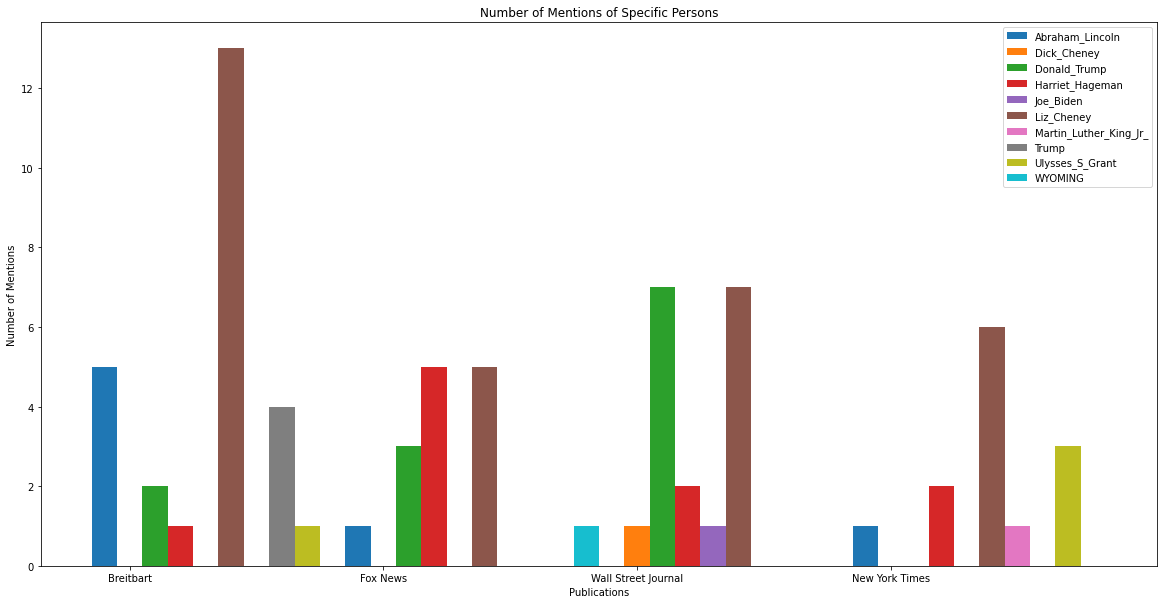

In [17]:
# Display a table of people and counts of their occurrences in the narratives
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy

pubs = list(publisher_dict.keys())
persons = list(person_mentions_dict.keys())
X_axis = np.arange(len(pubs))
start = -0.1
for person, count_array in person_mentions_dict.items():
    plt.bar(X_axis + start, count_array, 0.1, label = person)
    start += 0.1

plt.rcParams['figure.figsize'] = [30, 15]
plt.xticks(X_axis, pubs)
plt.xlabel("Publications")
plt.ylabel("Number of Mentions")
plt.title("Number of Mentions of Specific Persons")
plt.legend()
plt.show()


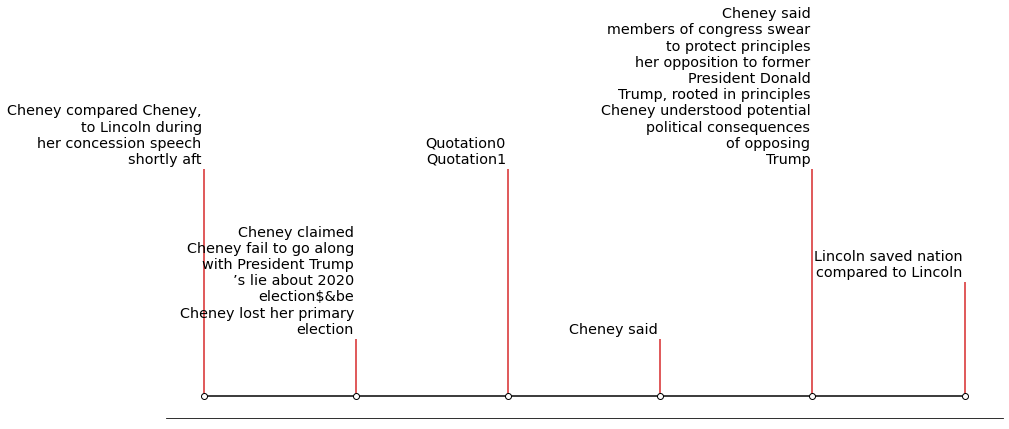

In [19]:
len_arc = len(story_arc_dict)
# For matplotlib timeline, need datetime formatting
title = 'Breitbart Article'
events = []
for key, arc_text in story_arc_dict.items():
    events.append(arc_text)
plot_dates = np.arange(len(events))
# Create a stem plot with some variation in levels as to distinguish close-by events.
# Add markers on the baseline with dates
# For each event, add a text label via annotate, which is offset from the tip of the event line
levels = np.tile([4, 1, 4, 1, 4, 2],
                 int(np.ceil(len(plot_dates) / 6)))[:len(plot_dates)]
# Create figure and plot a stem plot with the dates
fig, ax = plt.subplots()
dpi = fig.get_dpi()
fig.set_size_inches(15, 5)
ax.vlines(plot_dates, 0, levels, color="tab:red")  # The vertical stems
ax.plot(plot_dates, np.zeros_like(plot_dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it
# Annotate lines
for d, l, r in zip(plot_dates, levels, events):
    ax.annotate(r, xy=(d, l),
                xytext=(-2, np.sign(l) * 3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top", fontsize='x-large')
# Format x-axis with yearly intervals
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize='medium')
# Remove x- and y-axis and spines
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.margins(y=0.1)
plt.rcParams['figure.figsize'] = [15, 8]
plt.show()

In [20]:
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections


In [21]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def number_of_pendants(g):
    """
    Equals the number of nodes with degree 1
    """
    pendants = 0
    for u in g:
        if g.degree[u] == 1:
            pendants += 1
    return pendants


def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)
    
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

LC-Left.ttl
rdflib Graph loaded successfully with 192 triples
networkx Graph loaded successfully with length 135
NETWORK SIZE
The network has 135 nodes and 190 edges

PENDANTS/Nodes with degree 1
The network has 79 pendants

DENSITY
The network density is 0.021006080707573246

DEGREE CENTRALITY
The mean degree centrality is 0.02100608070757329, with stdev 0.020773943496003675
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.11940298507462686
The minimum node is Harriet Hageman, with value 0.007462686567164179
(0.11940298507462686, 0.09701492537313433, 0.07462686567164178, 0.06716417910447761, 0.05970149253731343, 0.04477611940298507, 0.03731343283582089, 0.029850746268656716, 0.022388059701492536, 0.014925373134328358, 0.007462686567164179) (1, 1, 3, 2, 1, 17, 11, 8, 3, 9, 79)


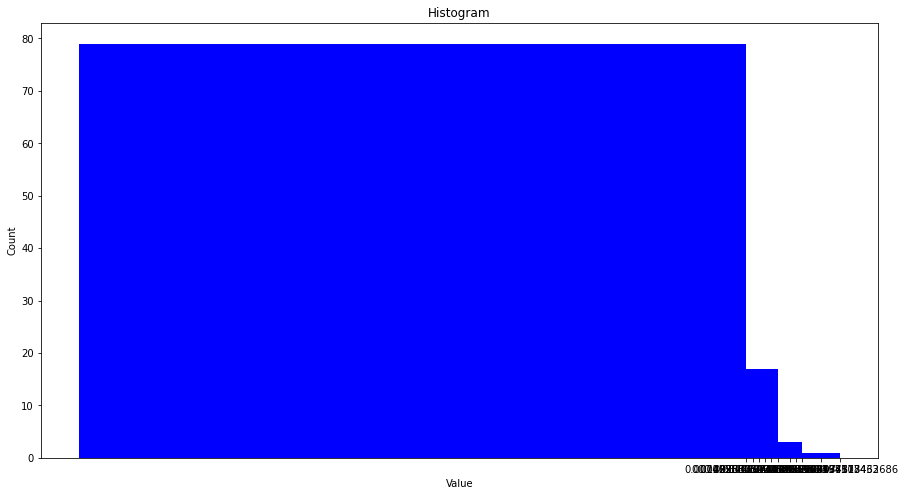


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.05167387716813297, with stdev 0.06908379113550867
The maximum node is urn:ontoinsights:dna:Chunk, with value 0.4035142802359184
The minimum node is more than 30 percentage point loss to Trump-endorsed Republican Harriet Hageman, with value 0.0014207712261218714
(0.4035142802359184, 0.304052383713264, 0.2509776340631398, 0.22682878585842886, 0.20900027679561806, 0.1989260753133008, 0.1981562294935518, 0.1971077692820251, 0.1936178411924289, 0.18865887074796162, 0.1817546942460326, 0.17421302825023302, 0.1715506140169869, 0.1657548853142782, 0.16099396033270622, 0.14985662413889603, 0.14181983855065186, 0.1373702903709384, 0.13338594315496677, 0.13075303754262876, 0.1240985956755833, 0.11935910246988506, 0.10685693962096877, 0.10580430881884628, 0.09455425217227667, 0.07935883372271721, 0.07286275605720809, 0.07114425701194939, 0.06921783193823865, 0.06677431782233414, 0.06640253286992055, 0.0603577099375772, 0.05227799

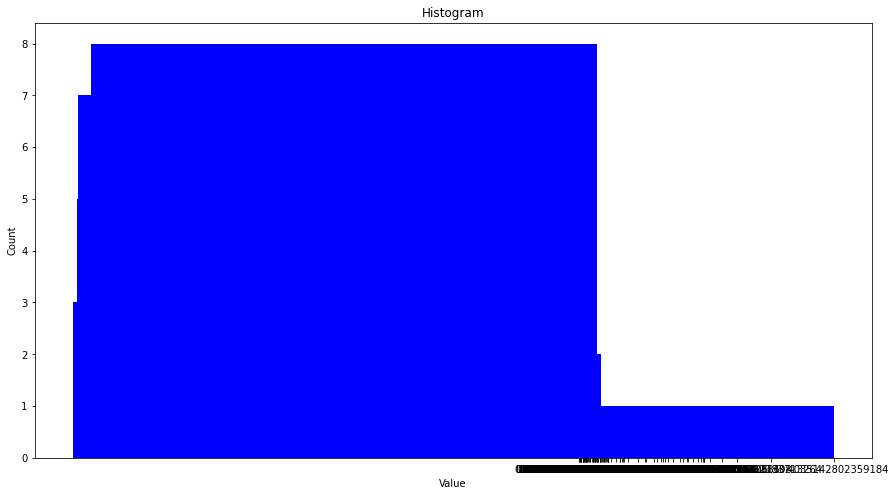


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.024792495334522036, with stdev 0.047309400284571757
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.2787978131168061
The minimum node is Harriet Hageman, with value 0.0
(0.2787978131168061, 0.2631825406673973, 0.20614715709347614, 0.12969037725699223, 0.11862568879360391, 0.11442029737530864, 0.11309202442562591, 0.10768850535811075, 0.10736326189305029, 0.0910132602905595, 0.09026971125658372, 0.09025729050341551, 0.08383078830817071, 0.08196299901756503, 0.07883879787315758, 0.0771091248952752, 0.07350465716530132, 0.06949263932124138, 0.06882686809504267, 0.06484484107076598, 0.06276790199736978, 0.06127779348236398, 0.06090694549044853, 0.06046786447134331, 0.05943379935830739, 0.05763104418555808, 0.05180548484080384, 0.0510196474036366, 0.04253728114209251, 0.04149383129816902, 0.039263704145546995, 0.03860694863284978, 0.03706513199567252, 0.03632579600293025, 0.03214164356572616, 0.02973852541802267, 

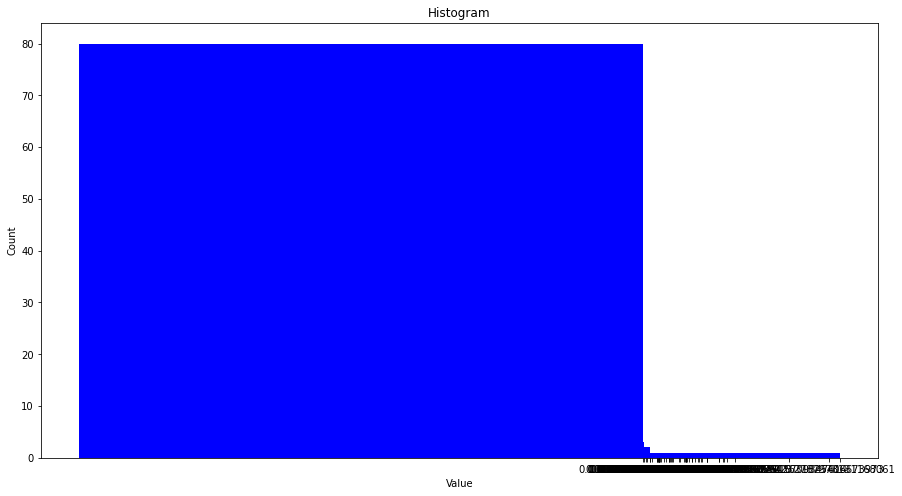


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 135 nodes

LC-Center.ttl
rdflib Graph loaded successfully with 335 triples
networkx Graph loaded successfully with length 239
NETWORK SIZE
The network has 239 nodes and 333 edges

PENDANTS/Nodes with degree 1
The network has 147 pendants

DENSITY
The network density is 0.01170844907000457

DEGREE CENTRALITY
The mean degree centrality is 0.011708449070004548, with stdev 0.013634375452516731
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.11764705882352941
The minimum node is 3, with value 0.004201680672268907
(0.11764705882352941, 0.08403361344537814, 0.06302521008403361, 0.04621848739495798, 0.04201680672268907, 0.037815126050420166, 0.03361344537815126, 0.029411764705882353, 0.025210084033613446, 0.021008403361344536, 0.01680672268907563, 0.012605042016806723, 0.008403361344537815, 0.004201680672268907) (1, 1, 1, 2, 3, 4, 3, 9, 18, 12, 11, 15, 12, 147)


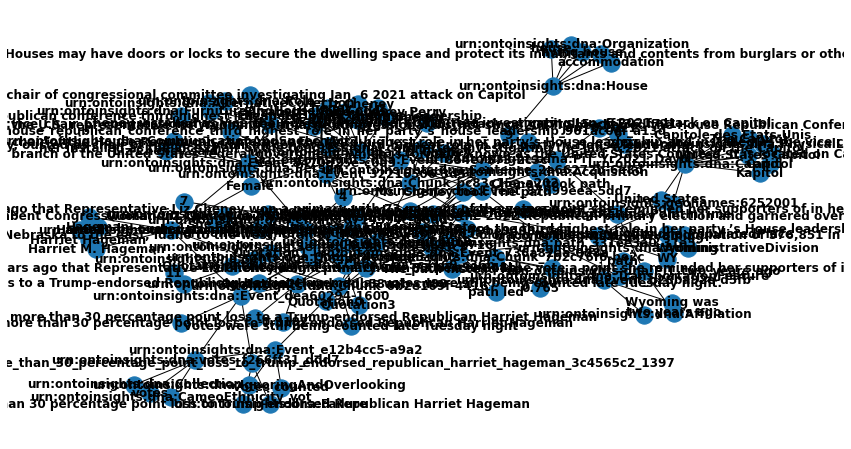

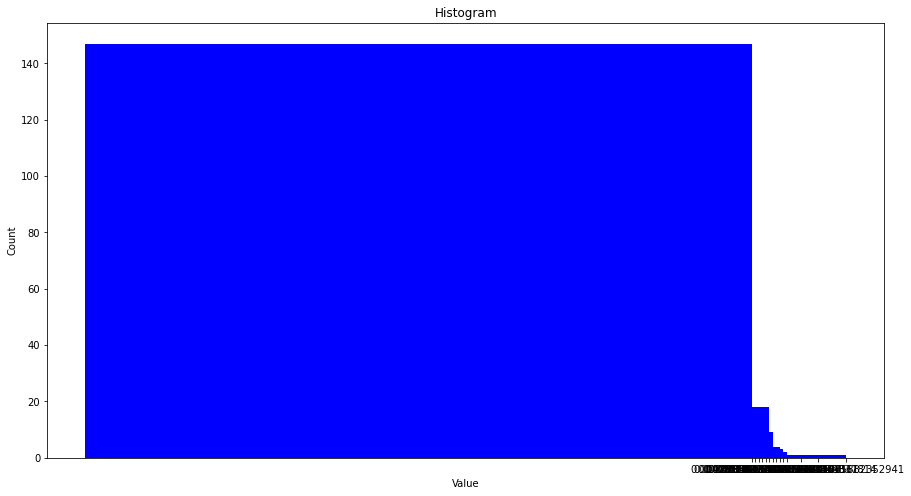


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.03920794631988471, with stdev 0.05155539282345882
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.3378391289646277
The minimum node is urn:ontoinsights:dna:Decrease, with value 0.00044691541444360263
(0.3378391289646277, 0.2882016503969303, 0.25529679596929516, 0.2520195026620805, 0.2265234570695464, 0.1933417485784205, 0.162639488363617, 0.15774683512735052, 0.15725804002049912, 0.1531520419500824, 0.13700858095597138, 0.13512214863584548, 0.13240064209922903, 0.12779164590716047, 0.1276664665040417, 0.1273526916002205, 0.12557528085856418, 0.12504519167692651, 0.12451635307592712, 0.12183511428208635, 0.12121544046053874, 0.1200661111703004, 0.11541609305716831, 0.11113385458237247, 0.10970569918317774, 0.10840021274855972, 0.10476683525397049, 0.10358891296319907, 0.1009608317157232, 0.09333465728485016, 0.0889141598189252, 0.08494519075924645, 0.07882259239338611, 0.07848778504100228, 0.0745426

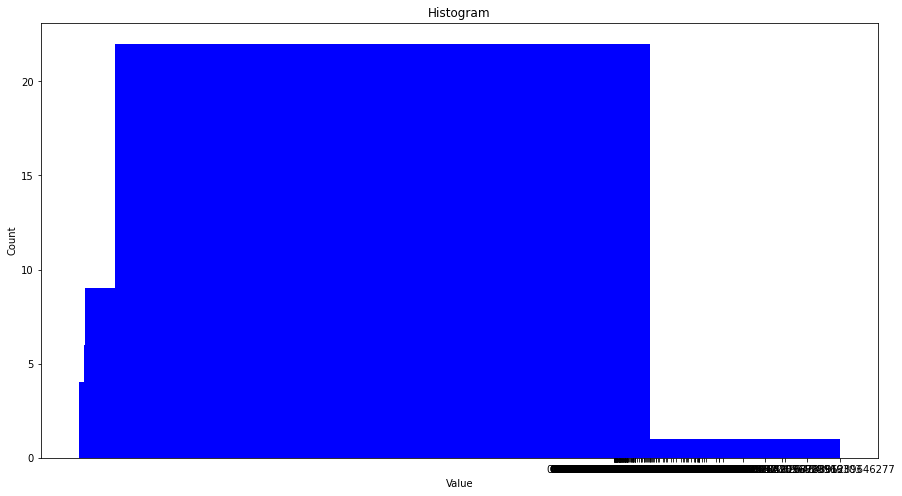


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.015276424642204743, with stdev 0.03359886372784151
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.22587914957166977
The minimum node is 3, with value 0.0
(0.22587914957166977, 0.21325542212334933, 0.20925170227437553, 0.17547021605273008, 0.1382939871921168, 0.10560572887695312, 0.09678536430215141, 0.09632622281901776, 0.07864233627279595, 0.07683173159511583, 0.07212869842812972, 0.0681901116304575, 0.06584895826213107, 0.06508481990076344, 0.06299422247157056, 0.06127464943617936, 0.060243390207290505, 0.05815980743426769, 0.05703812629217647, 0.05693469486822193, 0.053186863220350766, 0.052152603335467555, 0.051942842403483146, 0.050305545974545555, 0.04998370463319315, 0.04923585745488875, 0.048963135975841995, 0.04853227267841309, 0.04736604299818051, 0.044575360705429536, 0.043579522273821676, 0.042777540611561096, 0.04266163162566636, 0.04261720975338149, 0.036250070718404456, 0.03421224352387475, 

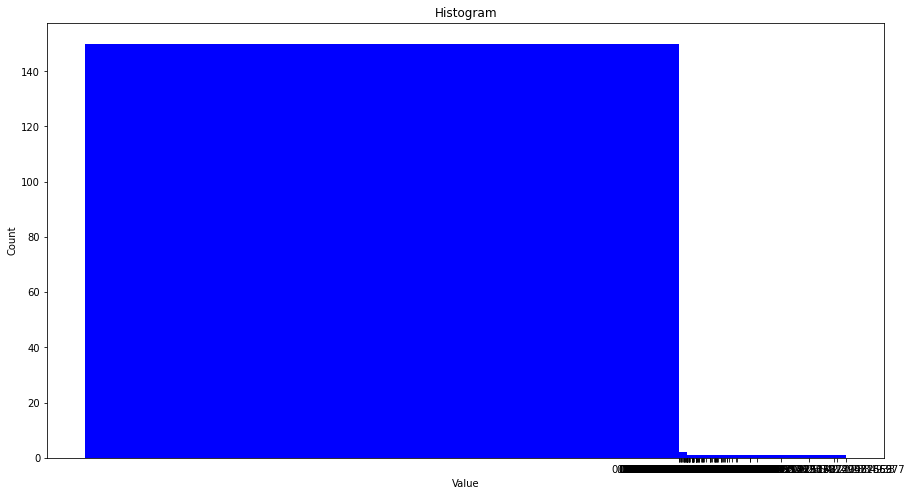


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 239 nodes

LC-Right.ttl
rdflib Graph loaded successfully with 253 triples
networkx Graph loaded successfully with length 188
NETWORK SIZE
The network has 188 nodes and 248 edges

PENDANTS/Nodes with degree 1
The network has 123 pendants

DENSITY
The network density is 0.014108544771873933

DEGREE CENTRALITY
The mean degree centrality is 0.014108544771873949, with stdev 0.017538291030573368
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.1443850267379679
The minimum node is Harriet M. Hageman, with value 0.0053475935828877
(0.1443850267379679, 0.1016042780748663, 0.0748663101604278, 0.0641711229946524, 0.053475935828877004, 0.0481283422459893, 0.0427807486631016, 0.0374331550802139, 0.0320855614973262, 0.026737967914438502, 0.0213903743315508, 0.0160427807486631, 0.0106951871657754, 0.0053475935828877) (1, 1, 1, 1, 1, 3, 5, 5, 11, 7, 11, 8, 10, 123)


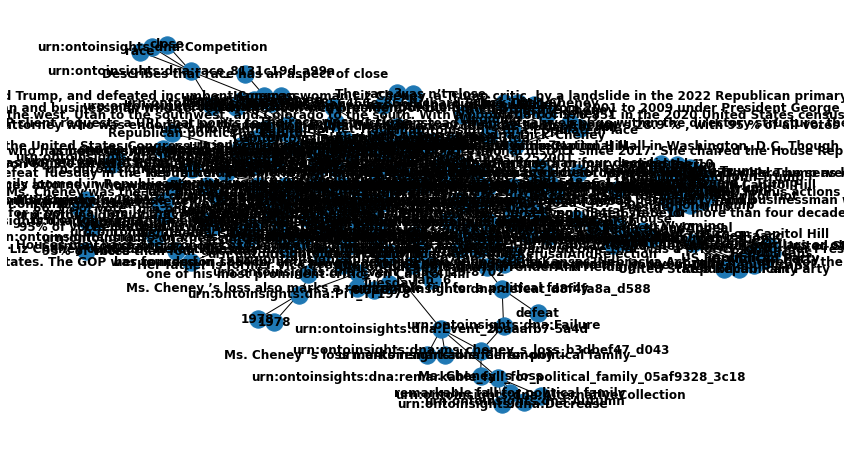

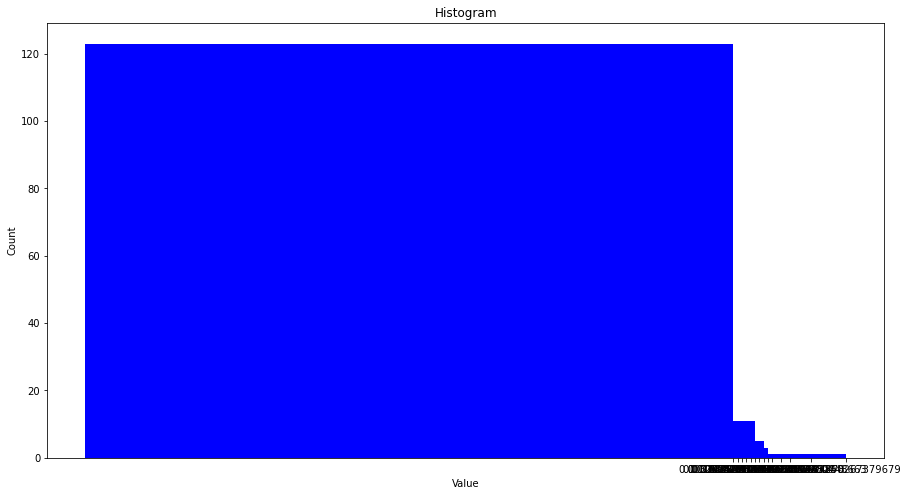


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.04629066268498398, with stdev 0.056509372421195296
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.3409253265784747
The minimum node is arguing that he should never be elected president again, with value 0.0005403403406548825
(0.3409253265784747, 0.3184186456308802, 0.23044227855329247, 0.22346907995236445, 0.2079312061798715, 0.20209784489595575, 0.1890912647268928, 0.18000025287322588, 0.17629850036327027, 0.17318707833526903, 0.16899879736099807, 0.16070103172614028, 0.15421714417188417, 0.1540060823959657, 0.12915513368939605, 0.12741593911984245, 0.1238437839828199, 0.11795047397175153, 0.11585684352399973, 0.11329690232839756, 0.10589934858404218, 0.1017460345388617, 0.10166989498894023, 0.10118157010216103, 0.09498461487175716, 0.09234910691850098, 0.09017258957983108, 0.08574447710096378, 0.0846282730892775, 0.08422069250714788, 0.08324639719827627, 0.0827029543400439, 0.08181293488102367, 0.

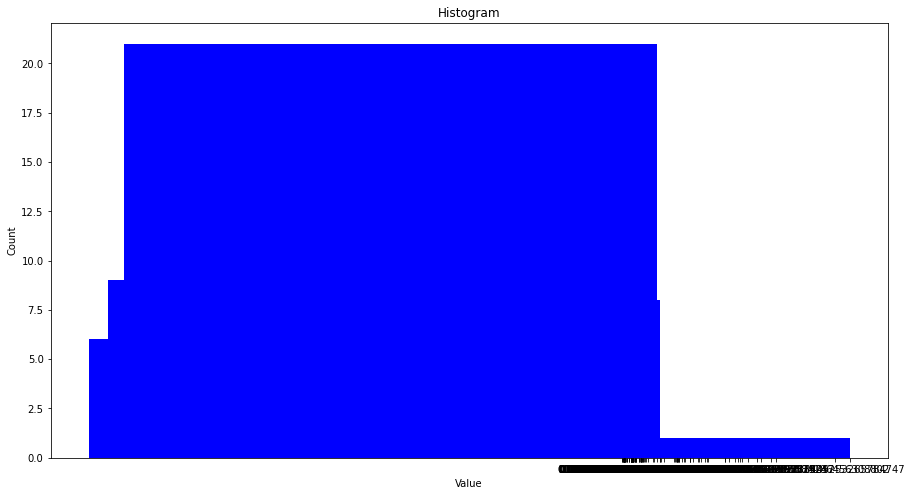


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.019330431367655308, with stdev 0.04541848738761785
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.3062809218547908
The minimum node is Harriet M. Hageman, with value 0.0
(0.3062809218547908, 0.268037110808699, 0.21142218933693435, 0.17032322179578127, 0.16663811567116352, 0.14501861671291408, 0.14126790677072537, 0.13237560842518975, 0.10908428455775393, 0.10890913603485182, 0.10084996306293811, 0.09747589181488772, 0.0972751499711966, 0.08737252832774235, 0.0850734623114592, 0.0825636559959336, 0.08000607947143358, 0.06844060064990078, 0.0680908747165666, 0.0653946734831991, 0.06073989928478086, 0.05700963862208523, 0.05311925725932971, 0.05290092576620091, 0.04793917963004907, 0.04743320170556191, 0.04253907210608953, 0.037301493470541305, 0.033609043386472685, 0.031913058478523375, 0.031886292249259575, 0.0306110193057162, 0.02905003964376781, 0.02812683977581277, 0.025621000994004533, 0.025608797505222

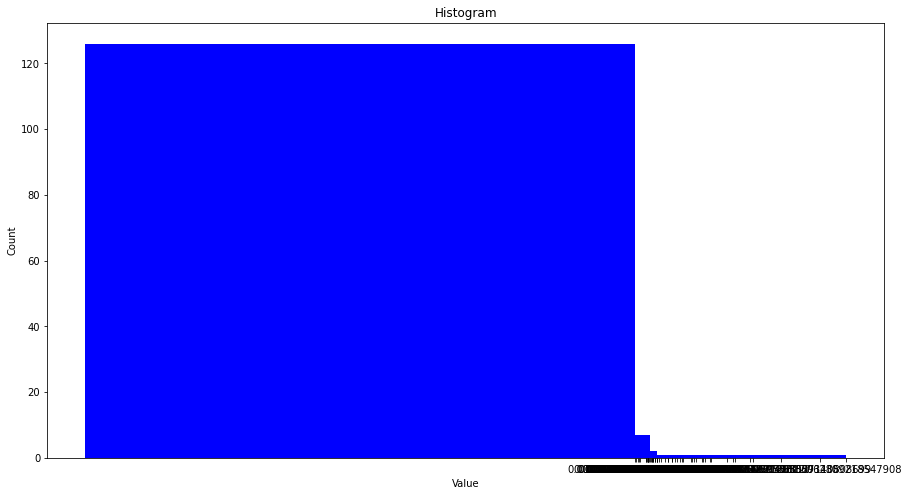


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 188 nodes

LC-Right.ttl
rdflib Graph loaded successfully with 253 triples
networkx Graph loaded successfully with length 188
NETWORK SIZE
The network has 188 nodes and 248 edges

PENDANTS/Nodes with degree 1
The network has 123 pendants

DENSITY
The network density is 0.014108544771873933

DEGREE CENTRALITY
The mean degree centrality is 0.014108544771873953, with stdev 0.017538291030573368
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.1443850267379679
The minimum node is pure delight, with value 0.0053475935828877
(0.1443850267379679, 0.1016042780748663, 0.0748663101604278, 0.0641711229946524, 0.053475935828877004, 0.0481283422459893, 0.0427807486631016, 0.0374331550802139, 0.0320855614973262, 0.026737967914438502, 0.0213903743315508, 0.0160427807486631, 0.0106951871657754, 0.0053475935828877) (1, 1, 1, 1, 1, 3, 5, 5, 11, 7, 11, 8, 10, 123)


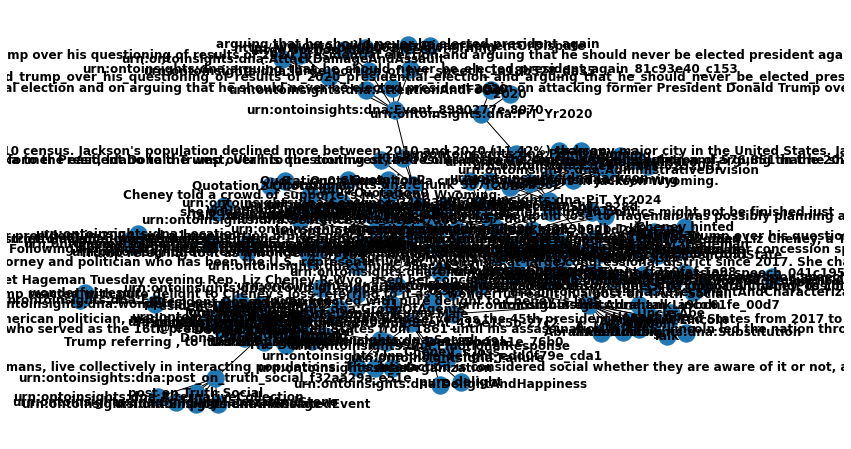

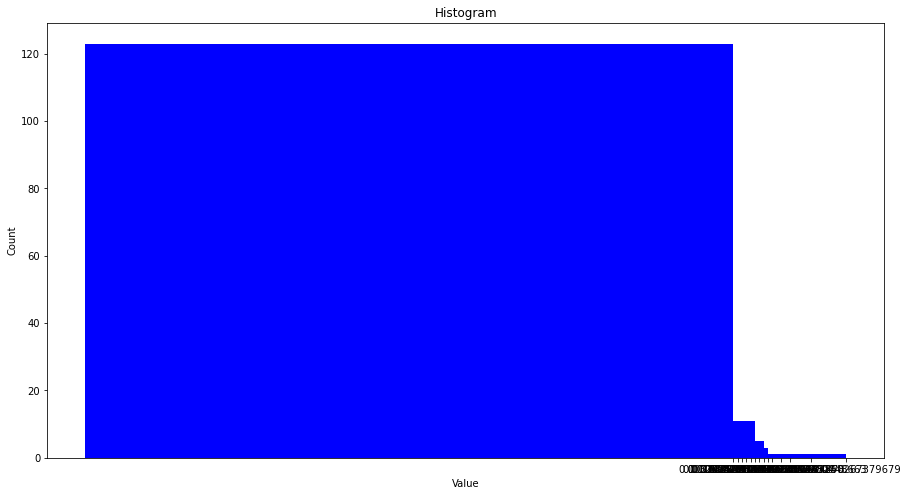


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.04629066268498401, with stdev 0.056509372421195296
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.34092532657847474
The minimum node is large portion of her speech, with value 0.0005403403406548825
(0.34092532657847474, 0.3184186456308802, 0.23044227855329247, 0.2234690799523645, 0.20793120617987151, 0.20209784489595575, 0.18909126472689283, 0.18000025287322585, 0.1762985003632703, 0.17318707833526906, 0.16899879736099804, 0.1607010317261403, 0.15421714417188417, 0.15400608239596567, 0.12915513368939605, 0.12741593911984245, 0.12384378398281991, 0.11795047397175154, 0.11585684352399973, 0.1132969023283976, 0.10589934858404217, 0.10174603453886172, 0.10166989498894026, 0.101181570102161, 0.09498461487175716, 0.09234910691850098, 0.09017258957983108, 0.08574447710096379, 0.08462827308927753, 0.08422069250714788, 0.08324639719827628, 0.08270295434004393, 0.08181293488102367, 0.08165320547794609, 0.0802

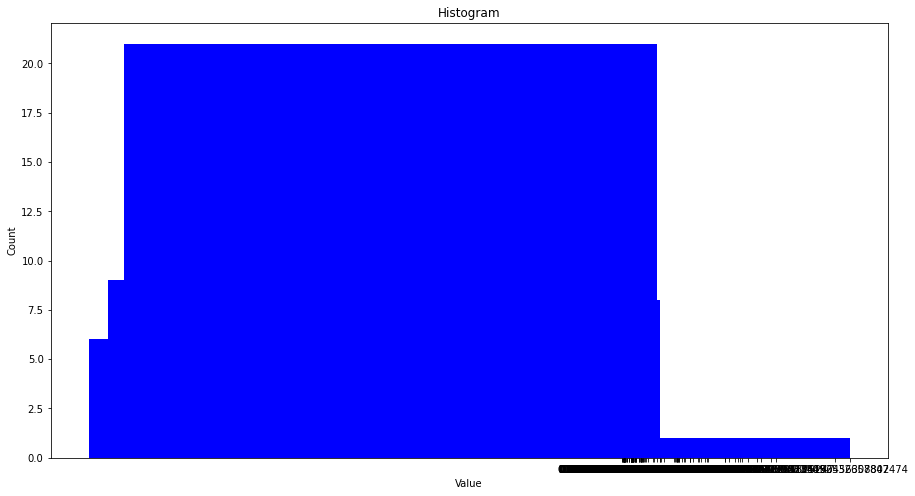


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.019330431367655315, with stdev 0.04541848738761786
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.30628092185479106
The minimum node is pure delight, with value 0.0
(0.30628092185479106, 0.2680371108086992, 0.21142218933693432, 0.17032322179578122, 0.16663811567116357, 0.14501861671291416, 0.14126790677072543, 0.13237560842518983, 0.10908428455775399, 0.1089091360348518, 0.10084996306293814, 0.0974758918148877, 0.0972751499711966, 0.08737252832774228, 0.08507346231145921, 0.08256365599593357, 0.08000607947143358, 0.0684406006499007, 0.06809087471656657, 0.06539467348319909, 0.0607398992847809, 0.057009638622085246, 0.0531192572593297, 0.05290092576620091, 0.04793917963004906, 0.047433201705561916, 0.042539072106089516, 0.03730149347054127, 0.03360904338647269, 0.031913058478523375, 0.03188629224925957, 0.0306110193057162, 0.029050039643767796, 0.028126839775812793, 0.025621000994004522, 0.02560879750522211

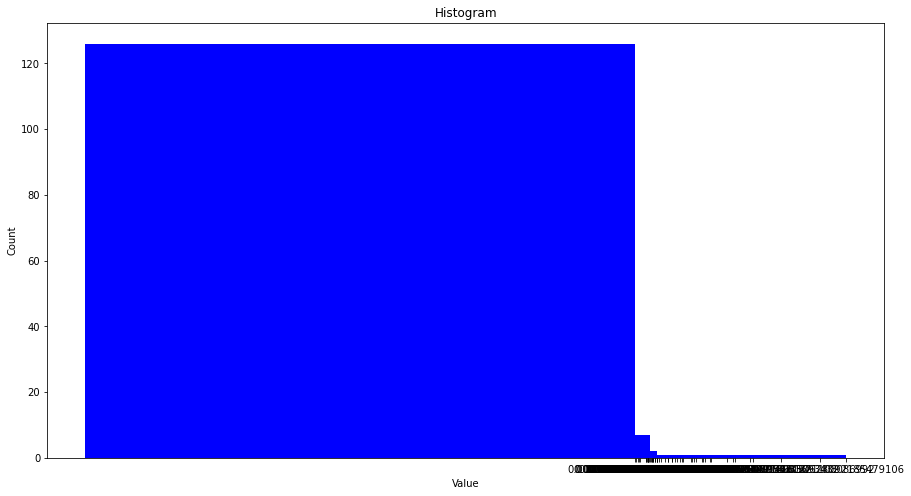


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 188 nodes



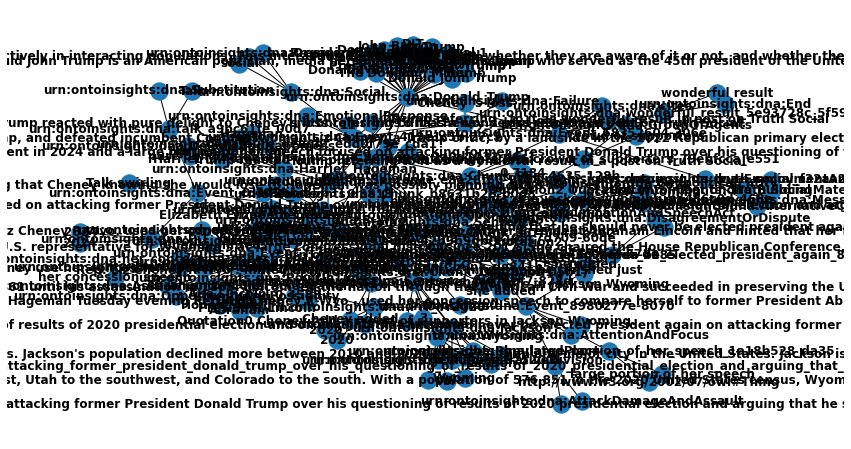

In [23]:
for i in range(4):
    # TTL files were saved from an earlier test run of DNA but can also be retrieved using the
    # GET /dna/v1/repositories/narratives/graphs API
    if i == 0:
        title = 'LC-Left.ttl'
    elif i == 1:
        title = 'LC-Center.ttl'
    elif i == 2:
        title = 'LC-Right.ttl'
    print(title)
    rg = RDFGraph()
    rg.parse(title, format='turtle')
    print("rdflib Graph loaded successfully with {} triples".format(len(rg)))
    G = rdflib_to_networkx_graph(rg)
    print("networkx Graph loaded successfully with length {}".format(len(G)))
    
    # Network size
    print("NETWORK SIZE")
    print("============")
    print("The network has {} nodes and {} edges".format(G.number_of_nodes(), G.number_of_edges()))
    print()

    # Network size
    print("PENDANTS/Nodes with degree 1")
    print("============")
    print("The network has {} pendants".format(number_of_pendants(G)))
    print()

    # Density
    print("DENSITY")
    print("============")
    print("The network density is {}".format(nx.density(G)))
    print()

    # Degree centrality -- mean and stdev
    dc = nx.degree_centrality(G)
    degrees = []
    for k,v in dc.items():
        degrees.append(v)

    print("DEGREE CENTRALITY")
    print("=================")
    print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
    print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
    histogram(dc)
    print()
    
    # Eigenvector centrality -- mean and stdev
    ec = nx.eigenvector_centrality(G)
    degrees = []
    for k,v in ec.items():
        degrees.append(v)

    print("EIGENVECTOR CENTRALITY")
    print("======================")
    print("The mean network eigenvector centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(ec, key=ec.get), max(ec.values())))
    print("The minimum node is {}, with value {}".format(min(ec, key=ec.get), min(ec.values())))
    histogram(ec)
    print()

    # Betweenness centrality -- mean and stdev
    bc = nx.betweenness_centrality(G)
    degrees = []
    for k,v in bc.items():
        degrees.append(v)
    print("BETWEENNESS CENTRALITY")
    print("======================")
    print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
    print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
    histogram(bc)
    print()

    # Plot
    print("Visualizing the graph:")
    plt.plot()
    nx.draw(G, with_labels=True, font_weight='bold')

    # Connected components
    cc = list(nx.connected_components(G))
    print("CONNECTED COMPONENTS")
    print("====================")
    print("The graph has {} connected components".format(len(cc)))
    for i,c in enumerate(cc):
        print("Connected component {} has {} nodes".format(i,len(c)))
    print()